
Running simulation with Greedy Nearest algorithm...
Initialized simulation with 1000 drivers and 2437 potential trips
Simulation period: 2025-01-01 08:00:00 to 2025-01-01 08:10:00
Starting simulation at 2025-01-01 08:00:00


100%|██████████| 10.0/10.0 [00:00<00:00, 35.03it/s]


Simulation completed at 2025-01-01 08:10:00

Simulation Results:
Total Completed Trips: 79
Total Cancelled Rides: 0
Average Waiting Time: 102.39 seconds
Average Trip Time: 86.37 seconds
Average Driver Earnings: $3.39
Average Empty Miles: 5.19 miles
Driver Earnings Gini Coefficient: 0.3659

Running simulation with Hungarian algorithm...
Initialized simulation with 1000 drivers and 2437 potential trips
Simulation period: 2025-01-01 08:00:00 to 2025-01-01 08:10:00
Starting simulation at 2025-01-01 08:00:00


100%|██████████| 10.0/10.0 [00:00<00:00, 23.90it/s]


Simulation completed at 2025-01-01 08:10:00

Simulation Results:
Total Completed Trips: 81
Total Cancelled Rides: 0
Average Waiting Time: 82.41 seconds
Average Trip Time: 79.30 seconds
Average Driver Earnings: $3.33
Average Empty Miles: 1.95 miles
Driver Earnings Gini Coefficient: 0.3590

Running simulation with Fairness (0.5) algorithm...
Initialized simulation with 1000 drivers and 2437 potential trips
Simulation period: 2025-01-01 08:00:00 to 2025-01-01 08:10:00
Starting simulation at 2025-01-01 08:00:00


100%|██████████| 10.0/10.0 [00:00<00:00, 20.30it/s]


Simulation completed at 2025-01-01 08:10:00

Simulation Results:
Total Completed Trips: 78
Total Cancelled Rides: 0
Average Waiting Time: 84.35 seconds
Average Trip Time: 87.48 seconds
Average Driver Earnings: $3.27
Average Empty Miles: 1.91 miles
Driver Earnings Gini Coefficient: 0.3580

Running simulation with Stable Matching algorithm...
Initialized simulation with 1000 drivers and 2437 potential trips
Simulation period: 2025-01-01 08:00:00 to 2025-01-01 08:10:00
Starting simulation at 2025-01-01 08:00:00


100%|██████████| 10.0/10.0 [00:00<00:00, 10.06it/s]


Simulation completed at 2025-01-01 08:10:00

Simulation Results:
Total Completed Trips: 83
Total Cancelled Rides: 0
Average Waiting Time: 78.70 seconds
Average Trip Time: 82.21 seconds
Average Driver Earnings: $3.49
Average Empty Miles: 9.60 miles
Driver Earnings Gini Coefficient: 0.3725

Running simulation with Stable + Fairness algorithm...
Initialized simulation with 1000 drivers and 2437 potential trips
Simulation period: 2025-01-01 08:00:00 to 2025-01-01 08:10:00
Starting simulation at 2025-01-01 08:00:00


100%|██████████| 10.0/10.0 [00:01<00:00,  5.46it/s]


Simulation completed at 2025-01-01 08:10:00

Simulation Results:
Total Completed Trips: 89
Total Cancelled Rides: 0
Average Waiting Time: 86.92 seconds
Average Trip Time: 81.15 seconds
Average Driver Earnings: $3.65
Average Empty Miles: 9.03 miles
Driver Earnings Gini Coefficient: 0.3807

Running simulation with Fair Hungarian algorithm...
Initialized simulation with 1000 drivers and 2437 potential trips
Simulation period: 2025-01-01 08:00:00 to 2025-01-01 08:10:00
Starting simulation at 2025-01-01 08:00:00


100%|██████████| 10.0/10.0 [00:00<00:00, 15.05it/s]


Simulation completed at 2025-01-01 08:10:00

Simulation Results:
Total Completed Trips: 81
Total Cancelled Rides: 0
Average Waiting Time: 94.65 seconds
Average Trip Time: 84.24 seconds
Average Driver Earnings: $3.39
Average Empty Miles: 2.24 miles
Driver Earnings Gini Coefficient: 0.3649


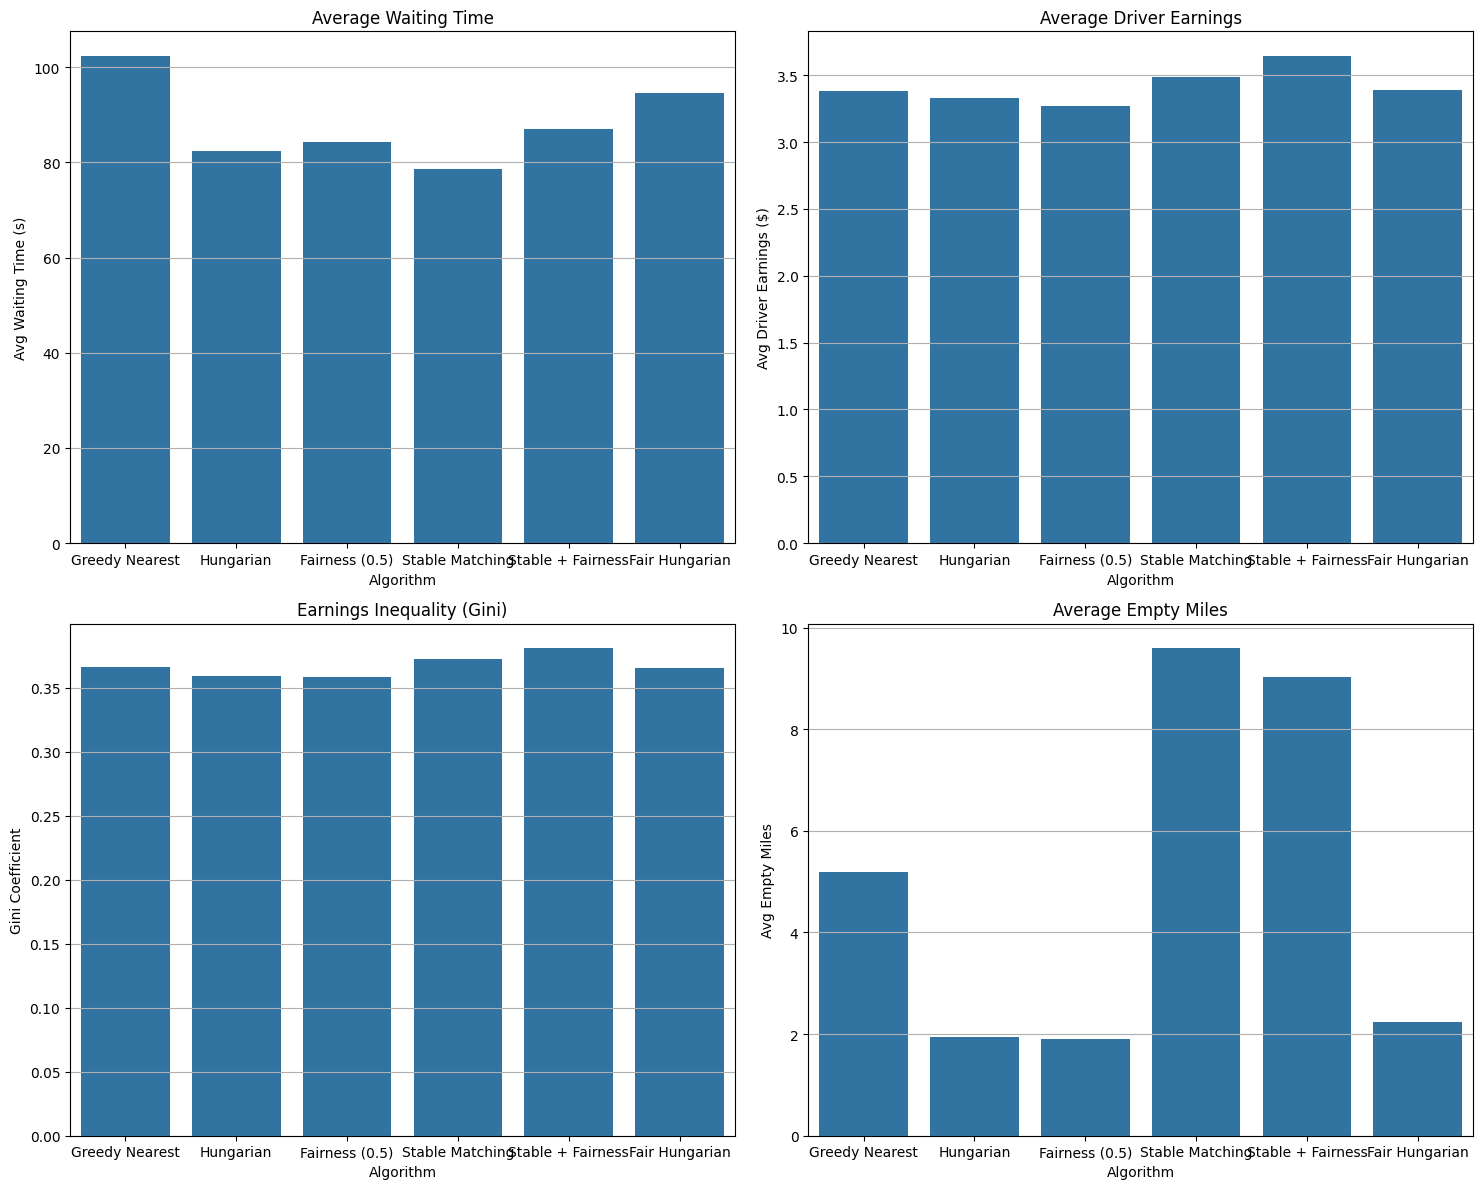

In [27]:
"""
Ride-Hailing Simulation Framework Architecture

Class Structure:
1. Entities: Rider, Driver, Trip
2. Environment: Simulation, City
3. Matching Algorithms: Base class + implementations
4. Metrics: Evaluation and visualization
"""
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import List, Dict, Tuple, Optional, Callable
from enum import Enum
import heapq
from abc import ABC, abstractmethod
from collections import defaultdict
import geopandas as gpd
from tqdm import tqdm

# --- Enumeration Classes ---

class DriverStatus(Enum):
    IDLE = 0
    ASSIGNED = 1
    EN_ROUTE_TO_PICKUP = 2
    ARRIVED_AT_PICKUP = 3
    WITH_RIDER = 4
    COMPLETED_TRIP = 5

class RiderStatus(Enum):
    WAITING = 0
    MATCHED = 1
    PICKED_UP = 2
    DROPPED_OFF = 3
    CANCELLED = 4

# --- Base Entity Classes ---

class Driver:
    def __init__(self, driver_id: str, initial_location_id: int):
        self.driver_id = driver_id
        self.location_id = initial_location_id
        self.status = DriverStatus.IDLE
        self.current_rider_id = None
        self.trip_history = []
        self.idle_since = None
        self.total_earnings = 0.0
        self.total_working_time = 0.0
        self.total_idle_time = 0.0
        self.total_distance = 0.0
        self.empty_distance = 0.0
        
    def assign_rider(self, rider_id: str, current_time: datetime):
        self.current_rider_id = rider_id
        self.status = DriverStatus.ASSIGNED
        if self.idle_since is not None:
            self.total_idle_time += (current_time - self.idle_since).total_seconds()
            self.idle_since = None
    
    def start_pickup(self):
        self.status = DriverStatus.EN_ROUTE_TO_PICKUP
    
    def arrive_at_pickup(self, location_id: int, current_time: datetime):
        self.location_id = location_id
        self.status = DriverStatus.ARRIVED_AT_PICKUP
    
    def start_trip(self, current_time: datetime):
        self.status = DriverStatus.WITH_RIDER
    
    def complete_trip(self, trip, current_time: datetime):
        """Complete a trip and update driver stats"""
        self.location_id = trip.dropoff_location_id
        self.status = DriverStatus.IDLE
        self.idle_since = current_time
        
        # Update statistics
        self.total_earnings += trip.driver_pay
        self.total_working_time += trip.trip_time
        self.total_distance += trip.trip_miles
        self.trip_history.append(trip.trip_id)
        self.current_rider_id = None
        
    def go_idle(self, current_time: datetime):
        self.status = DriverStatus.IDLE
        self.idle_since = current_time
        self.current_rider_id = None


class Rider:
    def __init__(self, rider_id: str, request_time: datetime, pickup_location_id: int, 
                 dropoff_location_id: int, shared_request: bool = False):
        self.rider_id = rider_id
        self.request_time = request_time
        self.pickup_location_id = pickup_location_id
        self.dropoff_location_id = dropoff_location_id
        self.shared_request = shared_request
        self.status = RiderStatus.WAITING
        self.assigned_driver_id = None
        self.pickup_time = None
        self.dropoff_time = None
        self.waiting_time = None
        self.cancel_time = None
        self.trip_id = None
        
    def assign_driver(self, driver_id: str):
        self.assigned_driver_id = driver_id
        self.status = RiderStatus.MATCHED
    
    def pickup(self, current_time: datetime):
        self.pickup_time = current_time
        self.waiting_time = (current_time - self.request_time).total_seconds()
        self.status = RiderStatus.PICKED_UP
    
    def dropoff(self, current_time: datetime):
        self.dropoff_time = current_time
        self.status = RiderStatus.DROPPED_OFF
    
    def cancel(self, current_time: datetime):
        self.cancel_time = current_time
        self.status = RiderStatus.CANCELLED


class Trip:
    def __init__(self, trip_id: str, rider_id: str, driver_id: str,
                 request_time: datetime, pickup_location_id: int, dropoff_location_id: int,
                 shared_request: bool = False):
        self.trip_id = trip_id
        self.rider_id = rider_id
        self.driver_id = driver_id
        self.request_time = request_time
        self.dispatch_time = None
        self.pickup_time = None
        self.dropoff_time = None
        self.pickup_location_id = pickup_location_id
        self.dropoff_location_id = dropoff_location_id
        self.shared_request = shared_request
        self.shared_match = False
        self.trip_miles = 0.0
        self.trip_time = 0.0
        self.base_fare = 0.0
        self.total_fare = 0.0
        self.driver_pay = 0.0
        
    def dispatch(self, current_time: datetime):
        self.dispatch_time = current_time
    
    def pickup(self, current_time: datetime):
        self.pickup_time = current_time
    
    def dropoff(self, current_time: datetime, trip_miles: float, trip_time: float, 
                base_fare: float, total_fare: float, driver_pay: float):
        self.dropoff_time = current_time
        self.trip_miles = trip_miles
        self.trip_time = trip_time
        self.base_fare = base_fare
        self.total_fare = total_fare
        self.driver_pay = driver_pay
        
    def calculate_waiting_time(self):
        if self.pickup_time and self.request_time:
            return (self.pickup_time - self.request_time).total_seconds()
        return None
    
    def is_completed(self):
        return self.dropoff_time is not None


# --- City Model ---

class City:
    def __init__(self, zone_data_path: str, travel_time_data_path: str = None):
        """
        Initialize city model with zone data and optional travel time matrix
        
        Args:
            zone_data_path: Path to TLC taxi zone shapefile or GeoJSON
            travel_time_data_path: Optional path to pre-computed travel time matrix
        """
        self.zones = gpd.read_file(zone_data_path)
        self.zone_id_to_index = {zone_id: idx for idx, zone_id in enumerate(self.zones['LocationID'])}
        
        # Load or initialize travel time/distance matrices
        if travel_time_data_path:
            self.travel_times = pd.read_csv(travel_time_data_path)
            # Convert to matrix format
            # self.time_matrix = self._create_matrix_from_df(self.travel_times)
        else:
            # Placeholder - in real implementation, would use distance between centroids or API
            num_zones = len(self.zones)
            self.time_matrix = np.random.uniform(5, 30, size=(num_zones, num_zones))
            np.fill_diagonal(self.time_matrix, 0)
            
        # Similar for distance matrix
        self.distance_matrix = np.random.uniform(0.5, 10, size=(len(self.zones), len(self.zones)))
        np.fill_diagonal(self.distance_matrix, 0)
    
    def get_travel_time(self, origin_id: int, destination_id: int) -> float:
        """Get estimated travel time between two zones in minutes"""
        try:
            orig_idx = self.zone_id_to_index[origin_id]
            dest_idx = self.zone_id_to_index[destination_id]
            return self.time_matrix[orig_idx, dest_idx]
        except KeyError:
            # Fallback for unknown zones
            return 15.0  # Default 15 minutes
    
    def get_travel_distance(self, origin_id: int, destination_id: int) -> float:
        """Get estimated travel distance between two zones in miles"""
        try:
            orig_idx = self.zone_id_to_index[origin_id]
            dest_idx = self.zone_id_to_index[destination_id]
            return self.distance_matrix[orig_idx, dest_idx]
        except KeyError:
            # Fallback for unknown zones
            return 3.0  # Default 3 miles
            
    def estimate_trip_fare(self, distance: float, time: float, dropoff_zone_id: int = None) -> Tuple[float, float, float]:
        base_fare = 2.55
        distance_fare = distance * 1.75
        time_fare = (time / 60) * 0.35
        fare = base_fare + distance_fare + time_fare

        # Congestion fee for Manhattan dropoffs (optional)
        congestion_surcharge = 0
        if dropoff_zone_id is not None and self.is_in_manhattan(dropoff_zone_id):
            congestion_surcharge = 2.75

        black_car_fund = fare * 0.025
        sales_tax = fare * 0.08875
        total_fare = fare + congestion_surcharge + black_car_fund + sales_tax
        driver_pay = fare * 0.75

        return fare, total_fare, driver_pay

    
    def is_in_manhattan(self, zone_id: int) -> bool:
        """Check if zone is in Manhattan (simplified)"""
        # Manhattan zones are typically 1-164
        return 1 <= zone_id <= 164


# --- Matching Algorithms ---

class MatchingAlgorithm(ABC):
    """Base class for matching algorithms"""
    
    @abstractmethod
    def match(self, riders: List[Rider], drivers: List[Driver], city: City, current_time: datetime) -> List[Tuple[Rider, Driver]]:
        """
        Match riders to drivers
        
        Args:
            riders: List of riders waiting to be matched
            drivers: List of available drivers
            city: City model for distance/time calculations
            current_time: Current simulation time
            
        Returns:
            List of (rider, driver) tuples representing matches
        """
        pass


class GreedyNearestNeighbor(MatchingAlgorithm):
    """Simple greedy algorithm that matches riders to nearest available drivers"""
    
    def match(self, riders: List[Rider], drivers: List[Driver], city: City, current_time: datetime) -> List[Tuple[Rider, Driver]]:
        matches = []
        available_drivers = [d for d in drivers if d.status == DriverStatus.IDLE]
        
        # Sort riders by request time (FCFS)
        sorted_riders = sorted(riders, key=lambda r: r.request_time)
        
        for rider in sorted_riders:
            if not available_drivers:
                break
                
            # Find closest driver
            closest_driver = min(
                available_drivers,
                key=lambda d: city.get_travel_time(d.location_id, rider.pickup_location_id)
            )
            
            # Make the match
            matches.append((rider, closest_driver))
            available_drivers.remove(closest_driver)
            
        return matches


class BatchedHungarianAlgorithm(MatchingAlgorithm):
    """Implementation of the Hungarian algorithm for optimal assignment"""
    
    def __init__(self, max_pickup_time: float = 15.0):
        """
        Initialize with constraints
        
        Args:
            max_pickup_time: Maximum acceptable pickup time in minutes
        """
        self.max_pickup_time = max_pickup_time
    
    def match(self, riders: List[Rider], drivers: List[Driver], city: City, current_time: datetime) -> List[Tuple[Rider, Driver]]:
        from scipy.optimize import linear_sum_assignment
        
        matches = []
        available_drivers = [d for d in drivers if d.status == DriverStatus.IDLE]
        
        if not riders or not available_drivers:
            return matches
            
        # Build cost matrix
        cost_matrix = np.zeros((len(riders), len(available_drivers)))
        
        for i, rider in enumerate(riders):
            for j, driver in enumerate(available_drivers):
                pickup_time = city.get_travel_time(driver.location_id, rider.pickup_location_id)
                
                # If pickup time exceeds max, set high cost
                if pickup_time > self.max_pickup_time:
                    cost_matrix[i, j] = 999999
                else:
                    cost_matrix[i, j] = pickup_time
        
        # Solve assignment problem
        try:
            rider_indices, driver_indices = linear_sum_assignment(cost_matrix)
            
            # Create matches where cost is acceptable
            for r_idx, d_idx in zip(rider_indices, driver_indices):
                if cost_matrix[r_idx, d_idx] < 999999:
                    matches.append((riders[r_idx], available_drivers[d_idx]))
                    
        except ValueError:
            # Fallback to greedy if optimization fails
            return GreedyNearestNeighbor().match(riders, drivers, city, current_time)
            
        return matches


class FairnessAwareMatching(MatchingAlgorithm):
    """Matching algorithm that considers driver fairness in addition to efficiency"""
    
    def __init__(self, fairness_weight: float = 0.3, efficiency_weight: float = 0.7, 
                 max_pickup_time: float = 15.0, income_lookback: int = 30):
        """
        Initialize with weights for multi-objective optimization
        
        Args:
            fairness_weight: Weight for fairness term (0-1)
            efficiency_weight: Weight for efficiency term (0-1)
            max_pickup_time: Maximum acceptable pickup time in minutes
            income_lookback: Number of past trips to consider for income fairness
        """
        self.fairness_weight = fairness_weight
        self.efficiency_weight = efficiency_weight
        self.max_pickup_time = max_pickup_time
        self.income_lookback = income_lookback
        
    def match(self, riders: List[Rider], drivers: List[Driver], city: City, current_time: datetime) -> List[Tuple[Rider, Driver]]:
        from scipy.optimize import linear_sum_assignment
        
        matches = []
        available_drivers = [d for d in drivers if d.status == DriverStatus.IDLE]
        
        if not riders or not available_drivers:
            return matches
        
        # Calculate income inequality factor for each driver
        # Lower value = driver has earned less than average
        mean_earnings = np.mean([d.total_earnings for d in available_drivers]) if available_drivers else 0
        std_earnings = np.std([d.total_earnings for d in available_drivers]) if available_drivers else 1
        
        income_factors = {}
        for driver in available_drivers:
            if std_earnings > 0:
                # Normalize earnings to z-score
                z_score = (driver.total_earnings - mean_earnings) / std_earnings
                # Transform to 0-1 range where 0 = lowest earner
                income_factors[driver.driver_id] = 1 / (1 + np.exp(-z_score))  # Sigmoid function
            else:
                income_factors[driver.driver_id] = 0.5
            
        # Build multi-objective cost matrix
        cost_matrix = np.zeros((len(riders), len(available_drivers)))
        
        for i, rider in enumerate(riders):
            for j, driver in enumerate(available_drivers):
                # Efficiency component: pickup time
                pickup_time = city.get_travel_time(driver.location_id, rider.pickup_location_id)
                if pickup_time > self.max_pickup_time:
                    cost_matrix[i, j] = 999999  # Disallow match
                    continue
                
                # Normalize pickup time to 0-1 range assuming max time is benchmark
                efficiency_cost = pickup_time / self.max_pickup_time
                
                # Fairness component: prioritize drivers with lower earnings
                fairness_cost = income_factors[driver.driver_id]
                
                # Combined cost function
                cost_matrix[i, j] = (
                    self.efficiency_weight * efficiency_cost + 
                    self.fairness_weight * fairness_cost
                )
        
        # Solve assignment problem
        try:
            rider_indices, driver_indices = linear_sum_assignment(cost_matrix)
            
            # Create matches where cost is acceptable
            for r_idx, d_idx in zip(rider_indices, driver_indices):
                if cost_matrix[r_idx, d_idx] < 999999:
                    matches.append((riders[r_idx], available_drivers[d_idx]))
                    
        except ValueError:
            # Fallback to greedy if optimization fails
            return GreedyNearestNeighbor().match(riders, drivers, city, current_time)
            
        return matches


# --- Shared Ride Matching ---

class SharedRideInsertionHeuristic(MatchingAlgorithm):
    """Matching algorithm for shared rides using insertion heuristics"""
    
    def __init__(self, max_detour_factor: float = 1.5, max_pickup_time: float = 10.0):
        self.max_detour_factor = max_detour_factor  # Maximum allowed detour relative to direct trip
        self.max_pickup_time = max_pickup_time  # Maximum initial pickup time
    
    def match(self, riders: List[Rider], drivers: List[Driver], city: City, current_time: datetime) -> List[Tuple[Rider, Driver]]:
        # First handle non-shared rides with basic algorithm
        non_shared_riders = [r for r in riders if not r.shared_request]
        shared_riders = [r for r in riders if r.shared_request]
        
        # Use basic matching for non-shared rides
        basic_matcher = GreedyNearestNeighbor()
        non_shared_matches = basic_matcher.match(non_shared_riders, drivers, city, current_time)
        
        # TODO: Implement shared ride matching with insertion heuristics
        # This would involve finding compatible rider pairs and assigning to drivers
        
        # For now, just use basic matching for shared rides too
        available_drivers = [d for d in drivers if d.status == DriverStatus.IDLE and 
                            d not in [match[1] for match in non_shared_matches]]
        
        shared_matches = basic_matcher.match(shared_riders, available_drivers, city, current_time)
        
        # Combine match results
        return non_shared_matches + shared_matches
    
class StableMatchingAlgorithm(MatchingAlgorithm):
    """
    Stable Matching (Gale–Shapley) based only on pickup distance/time.
    """

    def match(self, riders: List[Rider], drivers: List[Driver], city: City, current_time: datetime) -> List[Tuple[Rider, Driver]]:
        if not riders or not drivers:
            return []

        # Tạo preference list theo thời gian pickup ngắn nhất
        rider_prefs = {
            rider.rider_id: sorted(drivers, key=lambda d: city.get_travel_time(d.location_id, rider.pickup_location_id))
            for rider in riders
        }
        driver_prefs = {
            driver.driver_id: sorted(riders, key=lambda r: city.get_travel_time(driver.location_id, r.pickup_location_id))
            for driver in drivers
        }

        # Chuyển sang danh sách ID
        rider_pref_ids = {r: [d.driver_id for d in prefs] for r, prefs in rider_prefs.items()}
        driver_pref_ids = {d: [r.rider_id for r in prefs] for d, prefs in driver_prefs.items()}

        # Gale–Shapley (riders propose)
        free_riders = set(rider_pref_ids.keys())
        proposals = {r: 0 for r in free_riders}
        matches = {}
        driver_engaged = {}

        while free_riders:
            r_id = free_riders.pop()
            prefs = rider_pref_ids.get(r_id, [])
            if proposals[r_id] >= len(prefs):
                continue
            d_id = prefs[proposals[r_id]]
            proposals[r_id] += 1

            if d_id not in driver_engaged:
                matches[r_id] = d_id
                driver_engaged[d_id] = r_id
            else:
                current_r = driver_engaged[d_id]
                pref_list = driver_pref_ids[d_id]
                if pref_list.index(r_id) < pref_list.index(current_r):
                    matches[r_id] = d_id
                    driver_engaged[d_id] = r_id
                    free_riders.add(current_r)
                else:
                    free_riders.add(r_id)

        # Trả về cặp đối tượng
        id_to_rider = {r.rider_id: r for r in riders}
        id_to_driver = {d.driver_id: d for d in drivers}

        return [
            (id_to_rider[r], id_to_driver[d])
            for r, d in matches.items()
            if id_to_rider[r].status == RiderStatus.WAITING and id_to_driver[d].status == DriverStatus.IDLE
        ]

class StableFairMatchingAlgorithm(MatchingAlgorithm):
    def __init__(self, city: City, central_zone_id: int, fairness_weight=0.3, centrality_weight=0.2):
        self.city = city
        self.central_zone_id = central_zone_id
        self.fairness_weight = fairness_weight
        self.centrality_weight = centrality_weight

    def match(self, riders, drivers, city, current_time):
        if not riders or not drivers:
            return []

        # --- Compute statistics ---
        mean_earnings = np.mean([d.total_earnings for d in drivers]) or 0.01
        max_distance_to_center = max(
            [city.get_travel_distance(d.location_id, self.central_zone_id) for d in drivers]
        ) or 1

        # --- Scoring ---
        rider_pref = {}
        driver_pref = {}

        for rider in riders:
            scores = []
            for driver in drivers:
                pickup_time = city.get_travel_time(driver.location_id, rider.pickup_location_id)
                fairness_score = 1 - (driver.total_earnings / mean_earnings)
                center_distance = city.get_travel_distance(driver.location_id, self.central_zone_id)
                center_score = 1 - (center_distance / max_distance_to_center)

                # Weighted score: lower is better
                score = (
                    0.5 * pickup_time +
                    self.fairness_weight * fairness_score +
                    self.centrality_weight * center_score
                )
                scores.append((score, driver))
            rider_pref[rider.rider_id] = [d.driver_id for _, d in sorted(scores, key=lambda x: x[0])]

        for driver in drivers:
            scores = []
            for rider in riders:
                pickup_time = city.get_travel_time(driver.location_id, rider.pickup_location_id)
                score = pickup_time
                scores.append((score, rider))
            driver_pref[driver.driver_id] = [r.rider_id for _, r in sorted(scores, key=lambda x: x[0])]

        # --- Stable matching (Gale–Shapley) ---
        free_riders = set(r.rider_id for r in riders)
        proposals = {r: 0 for r in free_riders}
        matches = {}
        driver_engaged = {}

        while free_riders:
            r_id = free_riders.pop()
            prefs = rider_pref.get(r_id, [])
            if proposals[r_id] >= len(prefs):
                continue
            d_id = prefs[proposals[r_id]]
            proposals[r_id] += 1

            if d_id not in driver_engaged:
                matches[r_id] = d_id
                driver_engaged[d_id] = r_id
            else:
                current_r = driver_engaged[d_id]
                pref_list = driver_pref[d_id]
                if pref_list.index(r_id) < pref_list.index(current_r):
                    matches[r_id] = d_id
                    driver_engaged[d_id] = r_id
                    free_riders.add(current_r)
                else:
                    free_riders.add(r_id)

        # Return final matched pairs
        id_to_rider = {r.rider_id: r for r in riders}
        id_to_driver = {d.driver_id: d for d in drivers}

        return [
            (id_to_rider[r], id_to_driver[d])
            for r, d in matches.items()
            if id_to_rider[r].status == RiderStatus.WAITING and id_to_driver[d].status == DriverStatus.IDLE
        ]
class FairHungarianAlgorithm(MatchingAlgorithm):
    def __init__(self, max_pickup_time=15.0, fairness_weight=0.3, centrality_weight=0.2):
        self.max_pickup_time = max_pickup_time
        self.fairness_weight = fairness_weight
        self.centrality_weight = centrality_weight

    def match(self, riders, drivers, city, current_time):
        from scipy.optimize import linear_sum_assignment
        matches = []
        available_drivers = [d for d in drivers if d.status == DriverStatus.IDLE]

        if not riders or not available_drivers:
            return matches

        # Stats
        mean_earnings = np.mean([d.total_earnings for d in available_drivers]) or 0.01
        max_dist_to_center = max([city.get_travel_distance(d.location_id, city.central_zone_id) for d in available_drivers]) or 1.0

        cost_matrix = np.zeros((len(riders), len(available_drivers)))

        for i, rider in enumerate(riders):
            for j, driver in enumerate(available_drivers):
                pickup_time = city.get_travel_time(driver.location_id, rider.pickup_location_id)
                if pickup_time > self.max_pickup_time:
                    cost_matrix[i, j] = 999999
                    continue

                # Normalize
                norm_pickup = pickup_time / self.max_pickup_time
                fairness = 1 - (driver.total_earnings / mean_earnings)  # thấp hơn trung bình thì điểm cao
                center_dist = city.get_travel_distance(driver.location_id, city.central_zone_id)
                center_score = center_dist / max_dist_to_center

                cost = (
                    0.5 * norm_pickup +
                    self.fairness_weight * fairness +
                    self.centrality_weight * center_score
                )

                cost_matrix[i, j] = cost

        try:
            rider_indices, driver_indices = linear_sum_assignment(cost_matrix)
            for r_idx, d_idx in zip(rider_indices, driver_indices):
                if cost_matrix[r_idx, d_idx] < 999999:
                    matches.append((riders[r_idx], available_drivers[d_idx]))
        except ValueError:
            return GreedyNearestNeighbor().match(riders, drivers, city, current_time)

        return matches

# --- Simulation ---

class Simulation:
    def __init__(self, city: City, matching_algorithm: MatchingAlgorithm):
        self._dropoff_metadata = {}
        self.city = city
        self.matching_algorithm = matching_algorithm
        self.current_time = None
        self.end_time = None
        self.time_step = None
        
        # Entities
        self.drivers = {}  # driver_id -> Driver
        self.riders = {}   # rider_id -> Rider
        self.trips = {}    # trip_id -> Trip
        
        # Event queue
        self.events = []  # heap queue of (time, event_type, entity_id)
        
        # Statistics
        self.metrics = {
            'total_matches': 0,
            'total_completed_trips': 0,
            'total_cancelled_rides': 0,
            'avg_waiting_time': 0,
            'avg_trip_time': 0,
            'avg_driver_earnings': 0,
            'avg_empty_miles': 0,
        }
        
        # Timestamped records for time series analysis
        self.time_series = {
            'waiting_times': [],     # (time, rider_id, waiting_time)
            'trip_completions': [],  # (time, trip_id)
            'driver_earnings': [],   # (time, driver_id, earnings)
            'matches': [],           # (time, rider_id, driver_id)
        }
    
    def initialize_from_data(self, driver_data_path: str, trip_data_path: str, 
                            start_date: datetime, end_date: datetime,
                            batch_interval_minutes: int = 1):
        """
        Initialize simulation from TLC data
        
        Args:
            driver_data_path: Path to driver data
            trip_data_path: Path to trip data in parquet format
            start_date: Simulation start date
            end_date: Simulation end date
            batch_interval_minutes: How often to run matching algorithm
        """
        self.current_time = start_date
        self.end_time = end_date
        self.time_step = timedelta(minutes=batch_interval_minutes)
        
        # Load trip data
        self.trip_df = pd.read_parquet(trip_data_path)
        
        # Convert timestamps
        for col in ['request_datetime', 'pickup_datetime', 'dropoff_datetime']:
            if col in self.trip_df.columns:
                self.trip_df[col] = pd.to_datetime(self.trip_df[col])
        
        # Filter by date range
        self.trip_df = self.trip_df[(self.trip_df['request_datetime'] >= start_date) & 
                                    (self.trip_df['request_datetime'] <= end_date)]
        
        # Sort by request time
        self.trip_df = self.trip_df.sort_values('request_datetime')
        
        # Initialize drivers - in a real scenario, would load from file
        # For now, create synthetic driver distribution
        self._initialize_synthetic_drivers(500)  # Start with 500 drivers
        
        print(f"Initialized simulation with {len(self.drivers)} drivers and {len(self.trip_df)} potential trips")
        print(f"Simulation period: {start_date} to {end_date}")
    
    def _initialize_synthetic_drivers(self, num_drivers: int):
        """Create synthetic drivers with distribution across zones"""
        # Get distribution of pickup locations to place drivers
        if len(self.trip_df) > 0 and 'PULocationID' in self.trip_df.columns:
            pickup_dist = self.trip_df['PULocationID'].value_counts(normalize=True)
            
            # Create drivers with distribution roughly matching pickups
            for i in range(num_drivers):
                driver_id = f"D{i:05d}"
                
                # Sample location from pickup distribution
                if len(pickup_dist) > 0:
                    location_id = np.random.choice(pickup_dist.index, p=pickup_dist.values)
                else:
                    # Fallback to random zone
                    location_id = np.random.choice(self.city.zones['LocationID'].values)
                
                self.drivers[driver_id] = Driver(driver_id, location_id)
        else:
            # Fallback if no trip data
            for i in range(num_drivers):
                driver_id = f"D{i:05d}"
                location_id = np.random.choice(self.city.zones['LocationID'].values)
                self.drivers[driver_id] = Driver(driver_id, location_id)
    
    def run(self):
        """Run the simulation from start to end time"""
        print(f"Starting simulation at {self.current_time}")
        
        progress_bar = tqdm(total=(self.end_time - self.current_time).total_seconds() // 60)
        
        # Main simulation loop
        while self.current_time < self.end_time:
            # Process events that happen at current time
            self._process_events()
            
            # Process new rider requests for this time step
            self._process_new_requests()
            
            # Run matching algorithm
            self._match_riders_to_drivers()
            
            # Update simulation time
            self.current_time += self.time_step
            progress_bar.update(self.time_step.total_seconds() // 60)
        
        progress_bar.close()
        print(f"Simulation completed at {self.current_time}")
        
        # Compute final metrics
        self._compute_final_metrics()
    
    def _process_events(self):
        """Process all events scheduled for current time"""
        while self.events and self.events[0][0] <= self.current_time:
            event_time, event_type, entity_id = heapq.heappop(self.events)
            
            if event_type == 'pickup':
                self._process_pickup_event(entity_id)
            elif event_type == 'dropoff':
                self._process_dropoff_event(entity_id)
            elif event_type == 'cancel':
                self._process_cancel_event(entity_id)
    
    def _process_new_requests(self):
        """Process new rider requests for the current time step"""
        # Get requests in current time window
        new_requests = self.trip_df[
            (self.trip_df['request_datetime'] >= self.current_time) & 
            (self.trip_df['request_datetime'] < self.current_time + self.time_step)
        ]
        
        for _, row in new_requests.iterrows():
            rider_id = f"R{len(self.riders):06d}"
            
            # Create new rider from trip data
            shared_request = row.get('shared_request_flag', 'N') == 'Y'
            
            rider = Rider(
                rider_id=rider_id,
                request_time=row['request_datetime'],
                pickup_location_id=row['PULocationID'],
                dropoff_location_id=row['DOLocationID'],
                shared_request=shared_request
            )
            
            self.riders[rider_id] = rider
    
    def _match_riders_to_drivers(self):
        """Run matching algorithm for current batch of riders"""
        # Get waiting riders
        waiting_riders = [r for r in self.riders.values() if r.status == RiderStatus.WAITING]
        
        if not waiting_riders:
            return
            
        # Get available drivers
        available_drivers = [d for d in self.drivers.values() if d.status == DriverStatus.IDLE]
        
        if not available_drivers:
            return
            
        # Run matching algorithm
        matches = self.matching_algorithm.match(waiting_riders, available_drivers, self.city, self.current_time)
        
        # Process matches
        for rider, driver in matches:
            self._create_trip(rider, driver)
            
            # Record match
            self.time_series['matches'].append((self.current_time, rider.rider_id, driver.driver_id))
            self.metrics['total_matches'] += 1
    
    def _create_trip(self, rider: Rider, driver: Driver):
        """Create a new trip from a rider-driver match"""
        trip_id = f"T{len(self.trips):06d}"
        
        # Create trip
        trip = Trip(
            trip_id=trip_id,
            rider_id=rider.rider_id,
            driver_id=driver.driver_id,
            request_time=rider.request_time,
            pickup_location_id=rider.pickup_location_id,
            dropoff_location_id=rider.dropoff_location_id,
            shared_request=rider.shared_request
        )
        
        # Update trip state
        trip.dispatch(self.current_time)
        self.trips[trip_id] = trip
        
        # Update rider state
        rider.assign_driver(driver.driver_id)
        rider.trip_id = trip_id
        
        # Update driver state
        driver.assign_rider(rider.rider_id, self.current_time)
        
        # Calculate pickup time
        pickup_time_mins = self.city.get_travel_time(driver.location_id, rider.pickup_location_id)
        pickup_time = self.current_time + timedelta(minutes=pickup_time_mins)
        
        # Schedule pickup event
        heapq.heappush(self.events, (pickup_time, 'pickup', trip_id))
        
        # Add empty mileage to driver
        empty_miles = self.city.get_travel_distance(driver.location_id, rider.pickup_location_id)
        driver.empty_distance += empty_miles
    
    def _process_pickup_event(self, trip_id: str):
        """Process a pickup event"""
        trip = self.trips[trip_id]
        rider = self.riders[trip.rider_id]
        driver = self.drivers[trip.driver_id]
        
        # Update trip
        trip.pickup(self.current_time)
        
        # Update rider
        rider.pickup(self.current_time)
        
        # Update driver
        driver.arrive_at_pickup(rider.pickup_location_id, self.current_time)
        driver.start_trip(self.current_time)
        
        # Record waiting time
        waiting_time = rider.waiting_time
        self.time_series['waiting_times'].append((self.current_time, rider.rider_id, waiting_time))
        
        # Calculate trip time and schedule dropoff
        trip_time_mins = self.city.get_travel_time(rider.pickup_location_id, rider.dropoff_location_id)
        trip_distance = self.city.get_travel_distance(rider.pickup_location_id, rider.dropoff_location_id)
        
        # Adjust for traffic conditions based on time of day (simplified)
        hour = self.current_time.hour
        if 7 <= hour <= 10 or 16 <= hour <= 19:  # Rush hours
            trip_time_mins *= 1.3  # 30% longer during rush hour
        
        dropoff_time = self.current_time + timedelta(minutes=trip_time_mins)
        
        # Calculate fare
        base_fare, total_fare, driver_pay = self.city.estimate_trip_fare(trip_distance, trip_time_mins, trip.dropoff_location_id)
        
        # Schedule dropoff with trip details
        self._dropoff_metadata[trip_id] = {
            'trip_miles': trip_distance,
            'trip_time': trip_time_mins * 60,
            'base_fare': base_fare,
            'total_fare': total_fare,
            'driver_pay': driver_pay
        }
        heapq.heappush(self.events, (dropoff_time, 'dropoff', trip_id))
    
    def _process_dropoff_event(self, trip_id: str):
        trip = self.trips[trip_id]
        rider = self.riders[trip.rider_id]
        driver = self.drivers[trip.driver_id]

        # Lấy metadata đã lưu từ pickup
        event_data = self._dropoff_metadata.pop(trip_id, {})

        # Complete trip
        trip.dropoff(
            self.current_time,
            event_data.get('trip_miles', 0),
            event_data.get('trip_time', 0),
            event_data.get('base_fare', 0),
            event_data.get('total_fare', 0),
            event_data.get('driver_pay', 0)
        )

        # Update rider & driver
        rider.dropoff(self.current_time)
        driver.complete_trip(trip, self.current_time)

        # Ghi lại thống kê
        self.time_series['trip_completions'].append((self.current_time, trip_id))
        self.metrics['total_completed_trips'] += 1
        self.time_series['driver_earnings'].append(
            (self.current_time, driver.driver_id, event_data.get('driver_pay', 0))
        )

    
    def _process_cancel_event(self, rider_id: str):
        """Process a ride cancellation"""
        rider = self.riders[rider_id]
        
        # Only process if rider is still waiting
        if rider.status == RiderStatus.WAITING:
            rider.cancel(self.current_time)
            self.metrics['total_cancelled_rides'] += 1
    
    def _compute_final_metrics(self):
        """Compute final performance metrics"""
        # Calculate averages
        completed_trips = [t for t in self.trips.values() if t.is_completed()]
        if completed_trips:
            self.metrics['avg_trip_time'] = np.mean([t.trip_time for t in completed_trips])
            
        picked_up_riders = [r for r in self.riders.values() if r.status == RiderStatus.DROPPED_OFF]
        if picked_up_riders:
            self.metrics['avg_waiting_time'] = np.mean([r.waiting_time for r in picked_up_riders])
        
        active_drivers = [d for d in self.drivers.values() if d.trip_history]
        if active_drivers:
            self.metrics['avg_driver_earnings'] = np.mean([d.total_earnings for d in active_drivers])
            self.metrics['avg_empty_miles'] = np.mean([d.empty_distance for d in active_drivers])
        
        # Calculate Gini coefficient for driver earnings
        if active_drivers:
            earnings = np.array([d.total_earnings for d in active_drivers])
            self.metrics['gini_coefficient'] = self._gini(earnings)
            
        print("\nSimulation Results:")
        print(f"Total Completed Trips: {self.metrics['total_completed_trips']}")
        print(f"Total Cancelled Rides: {self.metrics['total_cancelled_rides']}")
        print(f"Average Waiting Time: {self.metrics['avg_waiting_time']:.2f} seconds")
        print(f"Average Trip Time: {self.metrics['avg_trip_time']:.2f} seconds")
        print(f"Average Driver Earnings: ${self.metrics['avg_driver_earnings']:.2f}")
        print(f"Average Empty Miles: {self.metrics['avg_empty_miles']:.2f} miles")
        if 'gini_coefficient' in self.metrics:
            print(f"Driver Earnings Gini Coefficient: {self.metrics['gini_coefficient']:.4f}")
    
    def _gini(self, array):
        """Calculate the Gini coefficient"""
        if np.amin(array) < 0:
            array -= np.amin(array)  # Make all values positive
        array = np.sort(array)  # Values must be sorted
        index = np.arange(1, array.shape[0] + 1)  # Index per array element
        n = array.shape[0]  # Number of array elements
        return (np.sum((2 * index - n - 1) * array)) / (n * np.sum(array))  # Gini coefficient


# --- Metrics and Visualization ---

class SimulationAnalyzer:
    """Class for analyzing simulation results and creating visualizations"""
    
    def __init__(self, simulation: Simulation):
        self.simulation = simulation
        self.results = simulation.metrics
        self.time_series = simulation.time_series
        
    def plot_waiting_time_distribution(self):
        """Plot distribution of rider waiting times"""
        waiting_times = [r.waiting_time for r in self.simulation.riders.values() 
                        if r.status == RiderStatus.DROPPED_OFF]
        
        plt.figure(figsize=(10, 6))
        sns.histplot(waiting_times, kde=True)
        plt.axvline(np.mean(waiting_times), color='r', linestyle='--', 
                   label=f'Mean: {np.mean(waiting_times):.2f}s')
        plt.title('Distribution of Rider Waiting Times')
        plt.xlabel('Waiting Time (seconds)')
        plt.ylabel('Count')
        plt.legend()
        plt.tight_layout()
        return plt
    
    def plot_driver_earnings_distribution(self):
        """Plot distribution of driver earnings"""
        earnings = [d.total_earnings for d in self.simulation.drivers.values() 
                   if d.trip_history]
        
        plt.figure(figsize=(10, 6))
        sns.histplot(earnings, kde=True)
        plt.axvline(np.mean(earnings), color='r', linestyle='--', 
                  label=f'Mean: ${np.mean(earnings):.2f}')
        plt.title('Distribution of Driver Earnings')
        plt.xlabel('Total Earnings ($)')
        plt.ylabel('Count')
        plt.legend()
        plt.tight_layout()
        return plt
    
    def plot_lorenz_curve(self):
        """Plot Lorenz curve for driver earnings inequality"""
        earnings = np.array([d.total_earnings for d in self.simulation.drivers.values() 
                           if d.trip_history])
        
        # Sort earnings
        earnings = np.sort(earnings)
        n = len(earnings)
        
        # Create points on the Lorenz curve
        lorenz_curve = np.cumsum(earnings) / np.sum(earnings)
        
        # Line of perfect equality
        equality_line = np.linspace(0, 1, n)
        
        plt.figure(figsize=(10, 6))
        plt.plot(np.linspace(0, 1, n), lorenz_curve, label='Lorenz Curve')
        plt.plot([0, 1], [0, 1], 'k--', label='Perfect Equality')
        plt.fill_between(np.linspace(0, 1, n), equality_line, lorenz_curve, alpha=0.2, 
                        label=f'Gini = {self.results["gini_coefficient"]:.4f}')
        plt.title('Lorenz Curve of Driver Earnings')
        plt.xlabel('Cumulative Share of Drivers')
        plt.ylabel('Cumulative Share of Earnings')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        return plt
    
    def plot_waiting_time_by_hour(self):
        """Plot average waiting time by hour of day"""
        # Extract hour from waiting time records
        waiting_data = pd.DataFrame(self.time_series['waiting_times'], 
                                  columns=['time', 'rider_id', 'waiting_time'])
        waiting_data['hour'] = waiting_data['time'].dt.hour
        
        # Group by hour and calculate mean
        hourly_avg = waiting_data.groupby('hour')['waiting_time'].mean().reset_index()
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x='hour', y='waiting_time', data=hourly_avg)
        plt.title('Average Waiting Time by Hour of Day')
        plt.xlabel('Hour of Day')
        plt.ylabel('Average Waiting Time (seconds)')
        plt.xticks(range(24))
        plt.grid(True, axis='y')
        plt.tight_layout()
        return plt
    
    def plot_trip_heatmap(self):
        """Plot heatmap of trip origins and destinations"""
        trips_df = pd.DataFrame([(t.pickup_location_id, t.dropoff_location_id) 
                               for t in self.simulation.trips.values() if t.is_completed()],
                              columns=['pickup', 'dropoff'])
        
        # Create matrix of zone pairs
        unique_zones = sorted(set(trips_df['pickup'].unique()) | set(trips_df['dropoff'].unique()))
        matrix = pd.crosstab(trips_df['pickup'], trips_df['dropoff'])
        
        # Fill missing zones
        for zone in unique_zones:
            if zone not in matrix.index:
                matrix.loc[zone] = 0
            if zone not in matrix.columns:
                matrix[zone] = 0
        
        # Sort zones for better visualization
        matrix = matrix.sort_index().sort_index(axis=1)
        
        # Plot heatmap (for large matrices, sample top zones by volume)
        if len(unique_zones) > 30:
            # Get top zones by total volume
            zone_volumes = matrix.sum(axis=1) + matrix.sum(axis=0)
            top_zones = zone_volumes.nlargest(30).index
            matrix = matrix.loc[top_zones, top_zones]
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(matrix, cmap="YlGnBu", annot=False)
        plt.title('Trip Origin-Destination Heatmap')
        plt.xlabel('Dropoff Zone')
        plt.ylabel('Pickup Zone')
        plt.tight_layout()
        return plt
    
    def plot_metrics_comparison(self, metrics_list, algorithm_names):
        """
        Compare metrics across different algorithms
        
        Args:
            metrics_list: List of metrics dictionaries from different algorithm runs
            algorithm_names: List of algorithm names
        """
        # Create comparison DataFrame
        comparison = pd.DataFrame({
            'Algorithm': algorithm_names,
            'Avg Waiting Time (s)': [m['avg_waiting_time'] for m in metrics_list],
            'Avg Trip Time (s)': [m['avg_trip_time'] for m in metrics_list],
            'Avg Driver Earnings ($)': [m['avg_driver_earnings'] for m in metrics_list],
            'Gini Coefficient': [m.get('gini_coefficient', 0) for m in metrics_list],
            'Avg Empty Miles': [m['avg_empty_miles'] for m in metrics_list],
        })
        
        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Plot comparisons
        sns.barplot(x='Algorithm', y='Avg Waiting Time (s)', data=comparison, ax=axes[0, 0])
        axes[0, 0].set_title('Average Waiting Time')
        axes[0, 0].grid(True, axis='y')
        
        sns.barplot(x='Algorithm', y='Avg Driver Earnings ($)', data=comparison, ax=axes[0, 1])
        axes[0, 1].set_title('Average Driver Earnings')
        axes[0, 1].grid(True, axis='y')
        
        sns.barplot(x='Algorithm', y='Gini Coefficient', data=comparison, ax=axes[1, 0])
        axes[1, 0].set_title('Earnings Inequality (Gini)')
        axes[1, 0].grid(True, axis='y')
        
        sns.barplot(x='Algorithm', y='Avg Empty Miles', data=comparison, ax=axes[1, 1])
        axes[1, 1].set_title('Average Empty Miles')
        axes[1, 1].grid(True, axis='y')
        
        plt.tight_layout()
        return plt


# --- Example Usage ---

def run_algorithm_comparison(trip_data_path, zone_data_path, start_date, end_date):
    """
    Run comparison of different matching algorithms
    
    Args:
        trip_data_path: Path to trip data
        zone_data_path: Path to zone data
        start_date: Simulation start date
        end_date: Simulation end date
    """
    # Initialize city
    city = City(zone_data_path)
    trip_df = pd.read_parquet(trip_data_path)
    city.central_zone_id = trip_df['PULocationID'].value_counts().idxmax()
    
    # Define algorithms to test
    algorithms = [
        ('Greedy Nearest', GreedyNearestNeighbor()),
        ('Hungarian', BatchedHungarianAlgorithm()),
        # ('Fairness (0.3)', FairnessAwareMatching(fairness_weight=0.3)),
        ('Fairness (0.5)', FairnessAwareMatching(fairness_weight=0.5)),
        ('Stable Matching', StableMatchingAlgorithm()),
        # ('Shared Rides', SharedRideInsertionHeuristic()),
        ('Stable + Fairness', StableFairMatchingAlgorithm(city, city.central_zone_id, fairness_weight=0.4, centrality_weight=0.2)),
        ('Fair Hungarian', FairHungarianAlgorithm()),
    ]
    
    # Results storage
    all_metrics = []
    algorithm_names = []
    
    for name, algorithm in algorithms:
        print(f"\nRunning simulation with {name} algorithm...")
        
        # Initialize simulation
        sim = Simulation(city, algorithm)
        sim.initialize_from_data(
            driver_data_path=None,  # Using synthetic drivers
            trip_data_path=trip_data_path,
            start_date=start_date,
            end_date=end_date,
            batch_interval_minutes=1
        )
        start_time = time.time()
        # Run simulation
        sim.run()
        duration = time.time() - start_time
        
        # Store results
        all_metrics.append(sim.metrics)
        algorithm_names.append(name)
        
    # Compare results
    analyzer = SimulationAnalyzer(sim)  # Use last simulation for analyzer
    analyzer.plot_metrics_comparison(all_metrics, algorithm_names)
    plt.show()


def main():
    # Example paths - replace with actual paths
    trip_data_path = "data/sample.parquet"
    zone_data_path = "data/taxi_zones/taxi_zones.shp"
    
    # Define simulation period
    start_date = datetime(2025, 1, 1, 8, 0, 0)  # 8 AM on January 1, 2023
    end_date = datetime(2025, 1, 1, 8, 10, 0)   # 6 PM on January 1, 2023
    
    # Run comparison
    run_algorithm_comparison(trip_data_path, zone_data_path, start_date, end_date)


if __name__ == "__main__":
    main()